# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Описание проекта

### Столбцы

|Столбец|Описание|Возможные значения/Примечание|
|--|--|--|
|`id`|номер записи||
|`adults`|количество взрослых постояльцев||
|`arrival_date_year`|год заезда||
|`arrival_date_month`|месяц заезда||
|`arrival_date_week_number`|неделя заезда||
|`babies`|количество младенцев||
|`arrival_date_day_of_month`|день заезда||
|`booking_changes`|количество изменений параметров заказа||
|`children`|количество детей от 3 до 14 лет||
|`country`|гражданство постояльца||
|`customer_type`|тип заказчика|`Contract`-договор с юридическим лицом;  `Group`-групповой заезд,  `Transient`-не связано с договором или групповым заездом;  `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа `Transient`|
|`days_in_waiting_list`|сколько дней заказ ожидал подтверждения||
|`distribution_channel`|канал дистрибуции заказа||
|`is_canceled`|отмена заказа|**Целевой признак**|
|`is_repeated_guest`|признак того, что гость бронирует номер второй раз||
|`lead_time`|количество дней между датой бронирования и датой прибытия||
|`meal`|опции заказа|`SC`-нет дополнительных опций; `BB`-включён завтрак; `HB` -включён завтрак и обед, `FB`-включён завтрак, обед и ужин.|
|`previous_bookings_not_canceled`|количество подтверждённых заказов у клиента||
|`previous_cancellations`|количество отменённых заказов у клиента||
|`required_car_parking_spaces`|необходимость места для автомобиля||
|`reserved_room_type`|тип забронированной комнаты||
|`stays_in_weekend_nights`|количество ночей в выходные дни||
|`stays_in_week_nights`|количество ночей в будние дни||
|`total_nights`|общее количество ночей||
|`total_of_special_requests`|количество специальных отметок.||

### Функции без функциональности

In [1]:
def decoratore_print_separator(text):
    '''Лучше не вникать. читал на днях про декораторы, решил попробовать пострадать фигней
    для красивого вывода информации'''
    def decorator_func(func):
        @wraps(func)
        def inner(*args, **kwargs):
            nonlocal text
            if args[0].name == 'train':
                part_text = ' в обучающей выборки'
            elif args[0].name == 'test':
                part_text = ' в тестовой выборки'
            else:
                part_text = ''
            len_txt = (80 - len(text) - len(part_text) + 2) // 2
            final_txt = '\n'
            if (len(text) + len(part_text)) % 2 == 1:
                final_txt += '-'
            for _ in range(len_txt):
                final_txt += '-'
            final_txt += f' {text} {part_text}'
            for _ in range(len_txt):
                final_txt += '-'
            final_txt += '\n'
            print(final_txt)
            return func(*args, **kwargs)
        return inner
    return decorator_func

### Шаг 1. Откройте файлы с данными

In [2]:
import pandas as pd
import pandas_profiling
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, recall_score, \
    precision_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import matplotlib
from functools import wraps
import numpy as np


matplotlib.style.use('seaborn-pastel')
pd.options.mode.chained_assignment = None


In [3]:
class Hotel():
    def __init__(self, path: str, name: str):
        '''.show_profile() - показывает информацию с помощью pandas_profiling
        '''
        self.path = path
        self.name = name
        self.read_csv_file()
        aaa = self.name
    
    def read_csv_file(self):
        '''Чтения файла

        Args:
            path (str): Путь к файлу
        '''
        try:
            self.df = pd.read_csv(self.path)
        except:
            self.df = pd.read_csv(f'/datasets/{self.path}')
    
    
    def show_profile(self, html_file=False):
        '''Показывает EDA аналитику, если html_file=True, генерирует отчет в html файл
        в формате {Название экземпляра класса}.html иначе выводит widget в JupyterNotebook

        Args:
            html_file (bool, optional):
        '''
        report = pandas_profiling.ProfileReport(self.df, explorative=True)
        if html_file:
            name_file = self.path.replace('.csv', '')
            report.to_file(f'{name_file}.html')
        else:
            report.to_widgets() 

In [4]:
test = Hotel('hotel_test.csv', 'test')
train = Hotel('hotel_train.csv', 'train')
train.show_profile(html_file=False) 

Generate report structure: 100%|██████████| 1/1 [00:10<00:00, 10.60s/it]


Посмотрев на данные в jupyter_viewer(vscode), сразу видно, что надо будет применять кодирование, переводить месяцы в числа, масштабировать, в связи с этим правильнее всего объединить данные, произвести Предобработку, а потом обратно соединить

### План по столбцам

In [5]:
# Дополнительные проверки
train.df['stays_in_weekend_nights'].sum() + train.df['stays_in_week_nights'].sum() == train.df['total_nights'].sum()

True

In [6]:
print(len(train.df.query('previous_bookings_not_canceled != 0')), len(train.df.query('is_repeated_guest != 0')))
print(len(train.df.query('previous_bookings_not_canceled != 0 and is_repeated_guest != 0')))

1543 1771
1263


- `id` - удалить, обучению не поможет  
- `arrival_date_year` - колебания туристов из года в год могут происходить из-за разных полит. факторов, маркетинга и т.п. и так как делаем прогноз на будущее, то данный признак имеет смысл удалить  
- `arrival_date_month` - необходимо перекодировать  
- `arrival_date_week_number` - очень большая корреляция с arrival_date_month и по сути признак дублирует предыдущий. удаляем  
- `arrival_date_day_of_month` - если бы еще был день недели, то имело бы смысл оставить... Стоит отметить что в тестовой выборке только 8мес. и если надо перевести в год, то не забываем умножать на 1.5  
- **из дня/месяца/года** надо достать сначало день недели и потом удалить.  
- `adults` - есть нулевые значения, заменим на единичку. Редкие значение перенесем в более часто встречающийся
- `children` - есть редкие значения(3ребенка - 16раз встречается), также сгруппируем
- `babies` - есть редкие значения и парочка выбросов, заменим на 1ребенка (сгруппируем)
- `meal` - записано криво с какими то пробелами, от этого SC дублируется. надо почистить а затем перекодировать (перед обучением)
- `distibution_channel` - перекодировать (перед обучением)
- `country` - Значения которые встречаются реже n раз... группируем в `other`, затем кодируем (перед обучением)
- `is_repeated_guest`, `previous_bookings_not_canceled` - очень похожи по описанию и вроде должна быть 100% линейная зависимость, но что то не совсем так... оставлю
`required_car_parking_spaces` - есть парочка редких значений(2/3) переведем в 1  
`total_nights` - бестолоковый признак, т.к. по сути является суммой выходные+будние дни. удаляем


### Шаг 2. Предобработка и исследовательский анализ данных

In [7]:
class Preprocessing(Hotel):
    def __init__(self, hotel: Hotel):
        self.df = hotel.df
        self.name = hotel.name
        self.change_strip_problems()
        self.change_month()
        self.data_preprocessing()
        self.delete_columns(
            ['id', 'year', 'day', 'arrival_date_week_number', 'total_nights'])

    def merge_values(self, x: pd.Series):
        '''
            x (pd.Series): values_counts_before_change
            return function(y, head, n)
        '''
        x = self.df[x].value_counts(ascending=True).sort_values(ascending=False).reset_index()
        x.columns = ['before', 'count_before']

        def inner(y: pd.Series, head=True, n=5):
            ''' Выводит на дисплей объединенной df - before | after
            y (pd.Series): values_counts_after_change
            n (int): длину возвращаемой таблицы, default=5
            head (bool): true - выведет head(n), иначе tail(n)

            '''
            nonlocal x
            y = self.df[y].value_counts(ascending=True).sort_values(ascending=False).reset_index()
            y.columns = ['after', 'count_after']
            if head:
                display(pd.concat([x, y], ignore_index=False, axis=1).head(n))
            else:
                display(pd.concat([x, y], ignore_index=False, axis=1).tail(n))

        return inner

    @decoratore_print_separator('Поменял месяца')
    def change_month(self):
        display_changing = self.merge_values('arrival_date_month')
        change = {'January': 1, 'February': 2, 'March': 3,
                  'April': 4, 'May': 5, 'June': 6,
                  'July': 7, 'August': 8, 'September': 9,
                  'October': 10, 'November': 11, 'December': 12}
        self.df['arrival_date_month'] = self.df['arrival_date_month'].replace(
            change)
        display_changing('arrival_date_month')

    @decoratore_print_separator('Получили столбец с днями недели')
    def data_preprocessing(self):
        '''Излекает дни недели из df, удаляет стобцы недель/дней в месяцу/года
        Рисует гистограмму
        '''
        dict_rename_columns = {
            'arrival_date_year': 'year',
            'arrival_date_month': 'month',
            'arrival_date_day_of_month': 'day'
        }
        self.df.rename(columns=dict_rename_columns, inplace=True)
        self.df['weekday'] = pd.to_datetime(
            self.df[['year', 'month', 'day']]).dt.weekday
        self.df['weekday'].plot(kind='hist', bins=7,
                                title='Заезды по дням неделям')
        plt.show()

    def delete_columns(self, columns_for_del):
        self.df.drop(columns=columns_for_del, inplace=True)
        print(f'Удалены следующие стобцы: {columns_for_del}')

    @decoratore_print_separator('Заменено')
    def group_smallest_values(self, show=True):
        '''Метод для удаления редких значений
        '''
        list_for_changing = [
            ['adults', lambda row: 1 if row == 0 else row],
            ['adults', lambda row: 3 if row == 4 else row],
            ['children', lambda row: 2 if row == 3 else row],
            ['babies', lambda row: 1 if row > 1 else row],
            ['required_car_parking_spaces', lambda row: 1 if row > 1 else row]]
        for col, func in list_for_changing:
            self.change_value(col, func, show)
        # self.change_value('adults', lambda row: 1 if row == 0 else row)

    def change_value(self, column, func, show):
        print(column)
        if show: display_change = self.merge_values(column)
        self.df[column] = self.df[column].apply(func)
        if show: display_change(column)
        
    @decoratore_print_separator('Убираем пробелы')    
    def change_strip_problems(self):
        '''Удаляет пробелы во всех категориальных признаках

        Args:
            show (bool): Если Тrue: выводит таблицу before | after, иначе не выводит
        '''
        columns_for_del_strips = ('meal', 'reserved_room_type', 'country', 'customer_type', 'distribution_channel')
        for column in columns_for_del_strips:
            print(f'Удаленны пробелы в колонке {column}')
            self.df[column] = self.df[column].str.strip()

        
    @decoratore_print_separator('Объединяем редкие страны')
    def group_countries(self, value):
        '''Страны которые встречаются реже чем "value" переименовывает в "other"

        Args:
            value (int): Лимит при котором страну считать "редкой"
        '''
        
        print(f'Было уникальных стран: {len(self.df["country"].unique())}')
        country_counts = self.df.groupby('country')['is_canceled'].count()
        self.df['country'] = self.df['country'].apply(lambda row: 'other' if country_counts[row] < value else row)
        print(f'Стало уникальных стран: {len(self.df["country"].unique())}')
        print(f'Страна считается редкой, если посетило меньше {value} туристов, за исследуемый период')
 

### Предобработка


------------------------ Убираем пробелы  в обучающей выборки-----------------------

Удаленны пробелы в колонке meal
Удаленны пробелы в колонке reserved_room_type
Удаленны пробелы в колонке country
Удаленны пробелы в колонке customer_type
Удаленны пробелы в колонке distribution_channel

------------------------ Поменял месяца  в обучающей выборки------------------------



,before,count_before,after,count_after
0,October,9255,10,9255
1,September,8782,9,8782
2,August,6678,8,6678
3,November,5761,11,5761
4,July,5718,7,5718



---------------- Получили столбец с днями недели  в обучающей выборки---------------



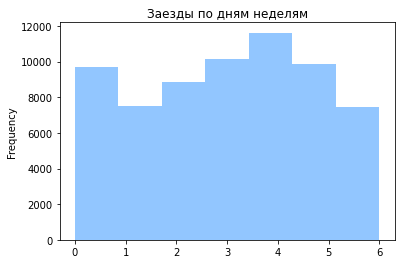

Удалены следующие стобцы: ['id', 'year', 'day', 'arrival_date_week_number', 'total_nights']

--------------------------- Заменено  в обучающей выборки---------------------------

adults


,before,count_before,after,count_after
0,2.0,48980,2.0,48980.0
1,1.0,13212,1.0,13378.0
2,3.0,2858,3.0,2858.0
3,0.0,166,4.0,13.0
4,4.0,13,NaN,NaN


adults


,before,count_before,after,count_after
0,2.0,48980,2.0,48980.0
1,1.0,13378,1.0,13378.0
2,3.0,2858,3.0,2871.0
3,4.0,13,NaN,NaN


children


,before,count_before,after,count_after
0,0.0,61712,0.0,61712.0
1,1.0,2165,1.0,2165.0
2,2.0,1336,2.0,1352.0
3,3.0,16,NaN,NaN


babies


,before,count_before,after,count_after
0,0.0,64777,0.0,64777.0
1,1.0,447,1.0,452.0
2,2.0,3,NaN,NaN
3,10.0,1,NaN,NaN
4,9.0,1,NaN,NaN


required_car_parking_spaces


,before,count_before,after,count_after
0,0,61547,0.0,61547.0
1,1,3670,1.0,3682.0
2,2,11,NaN,NaN
3,3,1,NaN,NaN



------------------- Объединяем редкие страны  в обучающей выборки-------------------

Было уникальных стран: 155
Стало уникальных стран: 40
Страна считается редкой, если посетило меньше 50 туристов, за исследуемый период

------------------------ Убираем пробелы  в тестовой выборки------------------------

Удаленны пробелы в колонке meal
Удаленны пробелы в колонке reserved_room_type
Удаленны пробелы в колонке country
Удаленны пробелы в колонке customer_type
Удаленны пробелы в колонке distribution_channel

------------------------- Поменял месяца  в тестовой выборки------------------------



,before,count_before,after,count_after
0,May,5262,5,5262
1,April,4878,4,4878
2,June,4580,6,4580
3,March,4277,3,4277
4,July,3626,7,3626



---------------- Получили столбец с днями недели  в тестовой выборки----------------



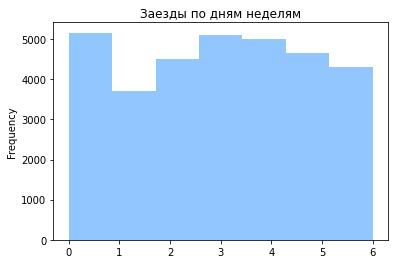

Удалены следующие стобцы: ['id', 'year', 'day', 'arrival_date_week_number', 'total_nights']

---------------------------- Заменено  в тестовой выборки---------------------------

adults


,before,count_before,after,count_after
0,2.0,24237,2.0,24237.0
1,1.0,6280,1.0,6349.0
2,3.0,1817,3.0,1817.0
3,0.0,69,4.0,9.0
4,4.0,9,NaN,NaN


adults


,before,count_before,after,count_after
0,2.0,24237,2.0,24237.0
1,1.0,6349,1.0,6349.0
2,3.0,1817,3.0,1826.0
3,4.0,9,NaN,NaN


children


,before,count_before,after,count_after
0,0.0,30360,0.0,30360.0
1,1.0,1394,1.0,1394.0
2,2.0,653,2.0,658.0
3,3.0,5,NaN,NaN


babies


,before,count_before,after,count_after
0,0.0,32237,0.0,32237.0
1,1.0,171,1.0,175.0
2,2.0,4,NaN,NaN


required_car_parking_spaces


,before,count_before,after,count_after
0,0,30935,0.0,30935.0
1,1,1468,1.0,1477.0
2,2,6,NaN,NaN
3,8,2,NaN,NaN
4,3,1,NaN,NaN



-------------------- Объединяем редкие страны  в тестовой выборки-------------------

Было уникальных стран: 143
Стало уникальных стран: 33
Страна считается редкой, если посетило меньше 50 туристов, за исследуемый период


In [8]:
for i in (train, test):
    preprocessing = Preprocessing(i)
    preprocessing.group_smallest_values(True)
    preprocessing.group_countries(50)

Из интересного в данных: 
- посетители сети из 155 разных стран
- по глобальной системе бронирования, всего 99(менее 0.1% пользователей) забронировали отель.
- оказывается существуют клиенты, которые отменяли заказ.... 25раз!!! я бы их после 5ого бы в черный список добавил
- странно, что 93.8% броннированных номеров - категория А.(как понимаю "элитная")
- существует не мало людей кто подтверждал заказ более 200дней... странная практика. при этом интересно, что при предсказывании отмены заказа наверно не правильно использовать этот параметр...
- Всего 0.4% посещают сеть отелей в группе. 4% юр.лица , а вот чем отличается `Transient` от `Transient-party` мне не понять, в сумме составляют 95% постояльцев
- На машинах приезжает ~6% постояльцев

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [67]:
class Business_metrics():
    '''Для вывода пользоваться методом start_profit_Hotel()
    '''
    def __init__(self):
        self.price_rooms = {
            'A' : [1000, 400], # Индекс / цена за ночь / разовое обслуживание
            'B' : [800, 350],
            'C' : [600, 350],
            'D' : [550, 150],
            'E' : [500, 150],
            'F' : [450, 150],
            'G' : [350, 150]
        }
        self.summer_koef = 1.4
        self.autumn_spring_koef = 1.2
        self.name = '' # костыль
        
    
    def calculate_profit_apply(self, row, predict, calculate_column='is_canceled'):
        '''Если predict = False, считает фактическую выручку иначе считает согласно предсказанию
        
        Считает предсказанную выручку по следующей формуле:
        если is_canceled == 0:(в любом случае отказа не было)
        стоимость ночи * кол-во дней * коэфициент - 
        (кол-во дней // 2 + кол-во дней % 2 + 1) * стоимость облуживания
        если is_canceled == 1 и predict == 1:(предсказала отказ, отказ произошел)
        стоимость ночи * 0.8 * коэфициент  ### Стоимость обслуживания не учитываем
        если is_canceled == 1 и predict == 0:(предсказала нет отказа, а отказ произошел)
        -(минус) стоимость обслуживания - стоимость ночи

        Args:
            predict_column (_type_): _description_
        '''
        if not predict:
            predict = 0
        else:
            predict = row[predict]
            
        count_days = row['stays_in_week_nights'] + row['stays_in_weekend_nights'] # кол-во дней
        koef = self.check_koef(row) # коэфициент
        night_price = self.price_rooms[row['reserved_room_type']][0] # Цена ночи
        service_price = self.price_rooms[row['reserved_room_type']][1] # Цена обслуживания
        service_count = count_days // 2 + count_days % 2 + 1 # обслуживания раз
        if row[calculate_column] == 1 and predict == 1: # отказ / отказ
            return night_price * koef * 0.8
        elif row[calculate_column] == 0: # нет отказа 
            profit = ((night_price*count_days*koef) - (service_price*service_count)) 
            return profit
        else: # отказ / нет отказа
            return night_price*(-1) - service_price 

        
               
    def check_koef(self, row):
        '''проверяет по полученной информации какой коэфициент применять'''
        if row['month'] < 2 or row['month'] > 11:
            return 1
        elif row['month'] > 5 and row['month'] < 9:
            return self.summer_koef
        else:
            return self.autumn_spring_koef
    
    def start_profit_hotel(self, hotel: Hotel, del_after=True):
        self.name = hotel.name
        self.df = hotel.df
        self.dont_ask_me_what_is_this(del_after)
        
    @decoratore_print_separator('Фактические значения')    
    def dont_ask_me_what_is_this(self, del_after):
        self.calculate_profit('is_canceled', del_after)    
        
    def calculate_profit(self, calculate_column, del_after, predict=False):
        '''Функция для подсчета основных бизнес метрик, после создания
        '''
        self.df['profit'] = self.df.apply(self.calculate_profit_apply, axis=1, predict=predict, calculate_column=calculate_column)
        # display(self.df['profit'].describe()) Можно расскоментировать
        sum_profit = self.df['profit'].sum() / 1_000_000
        profit_one_person = self.df['profit'].sum() / len(self.df['profit']) * 1.5
        sum_year_prof = sum_profit*1.5
        print(f'Общая выручка за рассмартиваемый период(8мес): {sum_profit:.2f} млн. руб')
        print(f'Расчетная выручка за год: {sum_year_prof:.2f} млн. руб')
        print(f'Средняя выручка на одного постояльца в год: {profit_one_person:.2f} руб')
        if not predict:
            per_errors = len(self.df.query('is_canceled == 1')) / len(self.df['profit'])
            print(f'Процент отказов: {per_errors:.2%}')
        else:
            self.df['mean_real_prof'] = self.df.apply(self.calculate_profit_apply, axis=1, predict=False, calculate_column='is_canceled')
            real_mean = self.df['mean_real_prof'].sum()
            prof =  sum_year_prof - ((real_mean*1.5)/ 1_000_000) 
            print(f'Предсказанное увеличение выручки в год: {prof:.2f} млн.руб')
            per_errors = len(self.df[self.df[predict] == 1]) / len(self.df['profit'])
            print(f'Процент предсказанных отказов: {per_errors:.2%}')
            self.df.drop(columns=['mean_real_prof'], inplace=True)  
        if del_after:
            self.df.drop(columns=['profit'], inplace=True)
        
        

In [68]:
Business_metrics().start_profit_hotel(test)



---------------------- Фактические значения  в тестовой выборки---------------------

Общая выручка за рассмартиваемый период(8мес): 32.61 млн. руб
Расчетная выручка за год: 48.91 млн. руб
Средняя выручка на одного постояльца в год: 1509.15 руб
Процент отказов: 38.85%


### Шаг 4. Разработка модели ML

In [11]:
class Preprocess_model():
    def __init__(self, test: Hotel, train: Hotel):
        self.test = test.df
        self.train = train.df
        self.main = self.test.copy()
        self.reverse_train = self.train.copy()
        self.reverse_test = self.test.copy()
        self.name = ''  # костыль

    def start_preprocess(self, scaler=False, ohe=False, ord_enc=False, show_value=False, del_obj=False):
        '''Метод возвращает выборки в зависимости от выбранных параметров

        Args:
            scaler (bool, optional): Применять ли масштабирование. Defaults to False.
            ohe (bool, optional): Кодирование Ohe. Defaults to False.
            ord_enc (bool, optional): Порядковое кодирование(не сочетается с ohe). Defaults to False.
            show_value (bool, optional): Выводить ли служ.информацию или нет. Defaults to False.
            del_obj (bool, optional): Удалить категориальные переменные(если не хочется кодировать). Defaults to False.
        '''
        self.columns_for_scale = ['lead_time', 'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'previous_cancellations', 'previous_bookings_not_canceled',
                                  'booking_changes', 'days_in_waiting_list', 'total_of_special_requests']
        self.columns_encording = ['reserved_room_type', 'customer_type', 'meal', 'country', 'distribution_channel']
        self.test = self.reverse_test.copy()
        self.train = self.reverse_train.copy()
        self.show_value = show_value
        self.scaler = scaler
        self.ohe = ohe
        self.ord_enc=ord_enc
        self.del_obj = del_obj
        self.features_train = self.train.drop(columns=['is_canceled'])
        self.features_test = self.test.drop(columns=['is_canceled'])
        self.target_train = self.train['is_canceled']
        self.target_test = self.test['is_canceled']
        if self.ohe:
            self.ohe_fit_features()
        if self.ord_enc:
            self.ordinal_encording()
        if self.scaler:
            self.scaler_fit()
        if self.del_obj:
            self.del_obj_func()
                
    @decoratore_print_separator('Удалил категориальные столбцы')
    def del_obj_func(self):
        self.features_train.drop(columns=self.columns_encording, inplace=True)
        self.features_test.drop(columns=self.columns_encording, inplace=True)

    @decoratore_print_separator('Перекодировано ohe')
    def ohe_fit_features(self):
        '''Обучается модель self.encoder_ohe (OneHotEncoder)
        '''
        if self.show_value:
            print(f'Размер таблицы до кодирования {self.features_train.shape}')
            count = 0
            for col in self.columns_encording:
                uniq_value = len(self.features_train[col].unique())
                print(
                    f'Количество уникальных значений в столбце {col} - {uniq_value}')
                count += uniq_value
            print(f'В сумме: {count}')
        self.encoder_ohe = OneHotEncoder(drop='first')
        self.encoder_ohe.fit(self.train[self.columns_encording])
        self.ohe_transform()
        if self.show_value:
            print(f'Размер таблицы после кодирования {self.features_train.shape}')


    def ohe_transform(self):
        '''Функция перекодирования методом ohe, сначало трансформирует, затем создается df
        затем удаляются стобцы из оригинального df
        '''

        encording_ohe_features = self.encoder_ohe.transform(self.features_train[self.columns_encording]).toarray()
        self.features_train.drop(columns=self.columns_encording, inplace=True)
        self.features_train[self.encoder_ohe.get_feature_names()] = pd.DataFrame(
            encording_ohe_features, columns=self.encoder_ohe.get_feature_names())
        
        # По сути повторение... падло в цикле не хочет менять значение...
        encording_ohe_features = self.encoder_ohe.transform(self.features_test[self.columns_encording]).toarray()
        self.features_test.drop(columns=self.columns_encording, inplace=True)
        self.features_test[self.encoder_ohe.get_feature_names()] = pd.DataFrame(
            encording_ohe_features, columns=self.encoder_ohe.get_feature_names())

        
    @decoratore_print_separator('Данные смасштабированы')
    def scaler_fit(self):
        scaler = StandardScaler()
        scaler.fit(self.features_train[self.columns_for_scale])
        scaled_train = scaler.transform(self.features_train[self.columns_for_scale])
        scaled_test = scaler.transform(self.features_test[self.columns_for_scale])
        self.features_train[self.columns_for_scale] = pd.DataFrame(
            scaled_train, columns=self.features_train[self.columns_for_scale].columns)
        self.features_test[self.columns_for_scale] = pd.DataFrame(
            scaled_test, columns=self.features_train[self.columns_for_scale].columns)
        if self.show_value:
            display(self.features_train.head(2))


    @decoratore_print_separator('Перекодировано порядковым способом')
    def ordinal_encording(self):
        if self.show_value:
            print(f'Размер таблицы до кодирования {self.features_train.shape}')
        ord_enc = OrdinalEncoder()
        ord_enc.fit(self.features_train[self.columns_encording])
        ord_data_train = ord_enc.transform(
            self.features_train[self.columns_encording])
        ord_data_test = ord_enc.transform(
            self.features_test[self.columns_encording])
        ord_data_train = pd.DataFrame(
            ord_data_train, columns=self.features_train[self.columns_encording].columns, index=self.features_train.index)
        ord_data_test = pd.DataFrame(
            ord_data_test, columns=self.features_test[self.columns_encording].columns, index=self.features_test.index)
        for i in [self.features_train, self.features_test]:
            i.drop(columns=self.columns_encording, inplace=True)
        self.features_train = pd.concat(
            [self.features_train, ord_data_train], axis=1)
        self.features_test = pd.concat(
            [self.features_test, ord_data_test], axis=1)
        if self.show_value:
            print(f'Размер таблицы после кодирования {self.features_train.shape}')
            display(self.features_train.head(2))


In [12]:
class Model_grid(Preprocess_model):
    '''Функции: 
    linear_regression() : создает модель Линейной регресии, выводит основные метрики


    Args:
        scaler(bool) : масштабировать(True) или не масштабировать признаки
        ohe(bool) : применять технику ohe или порядковое кодирование
        test(Hotel) : тестовый экземпляр класса Hotel
        train(Hotel) : тестовый экземпляр класса Hotel
    '''

    def __init__(self, test: Hotel, train: Hotel):
        super().__init__(test, train)

        
    @decoratore_print_separator('Логистическая регрессия')
    def linear_regression(self, class_weight=None):
        parametrs = {
            'penalty':['l1','l2']
        }
        model_logical = LogisticRegression(solver='liblinear', class_weight=class_weight)
        self.learn_model(model_logical, parametrs, 'logistic')
              
    
    @decoratore_print_separator('Дерево Решений')
    def tree_classifier(self, class_weight=None):
        parametrs = {
            'max_depth' : range(2,12,2),
            'min_samples_leaf' : range(1,10,2)
        }
        model_tree = DecisionTreeClassifier(random_state=333, class_weight=class_weight)
        self.learn_model(model_tree, parametrs, 'tree')
        
        
    @decoratore_print_separator('Случайный лес')
    def forest_classifier(self, class_weight=None):
        parametrs = {'n_estimators': range (30, 121, 10),
              'max_depth': range (4,13, 1),
              'min_samples_leaf': range (1,3)}
        model_forest = RandomForestClassifier(random_state=333, class_weight=class_weight)
        self.learn_model(model_forest, parametrs, 'forest')
        
        
    def learn_model(self, model, parametrs, text):
        '''Обучение модели через сетку

        Args:
            model (model): RandomForestClassifier/DecisionTreeClassifier/LogicalRegression
            parametrs (paramerts): словарь с параметрами для обучения
            text (str): Текст, как будет записан в основную таблицу
        '''
        grid = GridSearchCV(model, parametrs, cv=3, scoring='f1')
        grid.fit(self.features_train, self.target_train)
        self.calc_and_print_score(grid, text)
    
        
    def calc_and_print_score(self, grid: GridSearchCV, text: str):
        '''Функция для вывода всей нужной информации(метрик/графиков)

        Args:
            grid (GridSearchCV): Обученная сетка
            text (str): название, которое будет записано в таблицу test_train
        '''
        predict = grid.predict(self.features_test)
        probabilities = grid.predict_proba(self.features_test)[:,]
        probabilities = list(map(lambda x: x[1], probabilities)) # positive
        self.print_info(predict, probabilities, grid)    
        self.create_new_column(predict, probabilities, text)    
        self.drew_graphics(probabilities, predict, grid)
        
        
    def print_info(self, predict, probabilities, grid: GridSearchCV):
        print(f'Лучшее f1-мера полученная на кросс-валидации: {grid.best_score_:.2f}')
        print(f'Лучшие параметры сетки: {grid.best_params_}')
        # Кривой какой то способ достать предсказания... Но другого не придумал, если посоветует ревьювер, буду рад
        scores = {
            'f1-мера' : f1_score(self.target_test, predict),
            'accuracy' : accuracy_score(self.target_test, predict),
            'recall' : precision_score(self.target_test, predict),
            'presion' : recall_score(self.target_test, predict),
            'aur_roc_score' : roc_auc_score(self.target_test, probabilities),
        }
        print('\nМетрики полученные на тестовой выборке:')      
        for i in scores:
            print(f'Параметр {i} : {scores[i]:.2f}')
        
    def create_new_column(self, predict, probabilities, text):
        predict_name = f'predict_{text}'
        proba_name = f'proba_{text}'
        if f'proba_{text}' in self.main.columns:
            self.main.drop(columns=[predict_name, proba_name], inplace=True)
        pred = pd.Series(predict, index=self.target_test.index, name=predict_name)
        proba = pd.Series(probabilities, index=self.target_test.index, name=proba_name)    
        self.main = pd.concat([self.main, pred, proba], axis=1)
    
    
    def drew_graphics(self, probabilities, predict, grid: GridSearchCV):
        fpr, tpr, thresolds = roc_curve(self.target_test, probabilities)
        conf_matrix = confusion_matrix(self.target_test, predict, labels=grid.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=grid.classes_)
        disp.plot()
        plt.show()
        plt.plot(fpr,tpr, label="ROC Curve",color="blue")
        plt.xlabel("False Positve Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        

Ц.признак умеренно сбалансирован, правильнее всего использовать f-меру, для выбора подходящей модели. 

In [13]:
model = Model_grid(test, train)


-------------------------------- Перекодировано ohe --------------------------------


------------------------------ Данные смасштабированы ------------------------------


------------------------------ Логистическая регрессия -----------------------------

Лучшее f1-мера полученная на кросс-валидации: 0.65
Лучшие параметры сетки: {'penalty': 'l1'}

Метрики полученные на тестовой выборке:
Параметр f1-мера : 0.68
Параметр accuracy : 0.76
Параметр recall : 0.70
Параметр presion : 0.66
Параметр aur_roc_score : 0.83


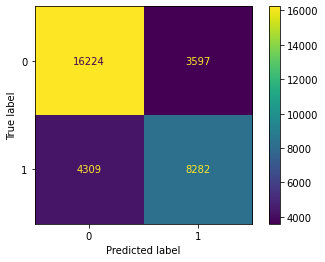

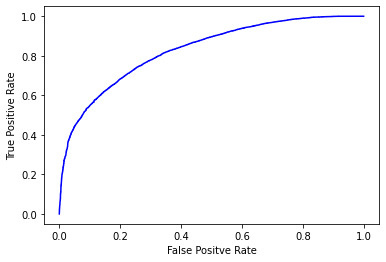

In [14]:
model.start_preprocess(ohe=True, scaler=True)
model.linear_regression('balanced')


-------------------------------- Перекодировано ohe --------------------------------


------------------------------ Данные смасштабированы ------------------------------


---------------------------------- Дерево Решений ----------------------------------

Лучшее f1-мера полученная на кросс-валидации: 0.60
Лучшие параметры сетки: {'max_depth': 6, 'min_samples_leaf': 9}

Метрики полученные на тестовой выборке:
Параметр f1-мера : 0.67
Параметр accuracy : 0.75
Параметр recall : 0.68
Параметр presion : 0.66
Параметр aur_roc_score : 0.82


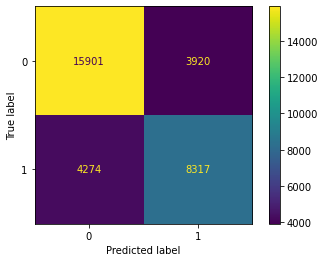

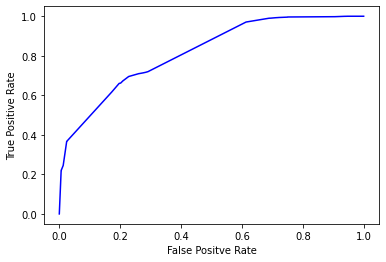

In [15]:
model.start_preprocess(scaler=True, ohe=True)
model.tree_classifier('balanced')


------------------------ Перекодировано порядковым способом ------------------------


------------------------------ Данные смасштабированы ------------------------------


----------------------------------- Случайный лес ----------------------------------

Лучшее f1-мера полученная на кросс-валидации: 0.63
Лучшие параметры сетки: {'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 60}

Метрики полученные на тестовой выборке:
Параметр f1-мера : 0.58
Параметр accuracy : 0.75
Параметр recall : 0.81
Параметр presion : 0.45
Параметр aur_roc_score : 0.80


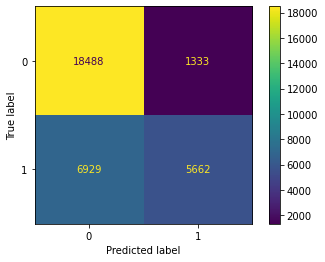

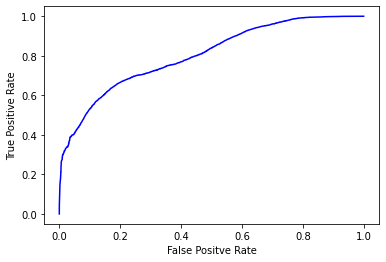

In [16]:
model.start_preprocess(ord_enc=True, scaler=True) 
model.forest_classifier('balanced')

In [69]:

class Predict_Business_metrics(Business_metrics):
    def __init__(self):
        super().__init__()
        self.name = '' 
    
    @decoratore_print_separator('Предсказанные значения')
    def start_profit_model(self, model : Model_grid, predict : str, text=False, calculate_column='is_canceled', del_after=True):
        if text:
            print(text)
        self.name = model.name
        self.df = model.main.copy()
        self.calculate_profit(calculate_column, del_after, predict=predict)
    
    @decoratore_print_separator('Предсказания на случайно модели')
    def random_profit(self, model : Model_grid, predict : str, text=False, calculate_column='is_canceled', del_after=True):
        if text:
            print(text)
        self.name = model.name
        self.df = model.main.copy()
        self.df['predict_random'] = 1
        self.calculate_profit(calculate_column, del_after, predict=predict)
        
    @decoratore_print_separator('Предсказания с помощью метода bootstrap')
    def bootstrap_function(self, model : Model_grid, predict: str):
        self.df = model.main.copy()
        predict_boot = self.df.apply(self.calculate_profit_apply, axis=1, predict=predict)
        real_boot = self.df.apply(self.calculate_profit_apply, axis=1, predict=False)
        values = []
        per_values = []
        state=np.random.RandomState(333)
        for _ in range(1000):
            predict_sum = predict_boot.sample(frac=1, replace=True, random_state=state).sum()
            real_sum = real_boot.sample(frac=1, replace=True, random_state=state).sum()
            values.append(predict_sum - real_sum)
            per_values.append(predict_sum / real_sum - 1)
        values = pd.Series(values)
        per_values = pd.Series(per_values)
        bad_var = len(values.loc[values<400000]) / len(values)
        per_values = per_values.mean()
        print(f'Средне предсказанное за рассматриваемый период(8мес) {values.mean()/1_000_000:.2f} млн. руб')
        mean_profit = values.mean()*1.5 / 1_000_000
        print(f'Средне предсказанное увеличение выручки в год {mean_profit:.2f} млн. руб')
        print(f'Увеличение выручки в % : {per_values:.2%}')
        # Так как выборка за 8месяцев, а не за год, то не знаю на сколько корректно выводить такие данные
        # print(f'99 квантиль: {values.quantile(.99):.1f}')
        # print(f'01 квантиль: {values.quantile(.01):.1f}')
        # print(f'Шанс получить убытки: {bad_var:.2%}')

In [71]:
Predict_Business_metrics().start_profit_hotel(test)
Predict_Business_metrics().random_profit(model, 'predict_random', 'Предсказали сплошные отказы')


---------------------- Фактические значения  в тестовой выборки---------------------

Общая выручка за рассмартиваемый период(8мес): 32.61 млн. руб
Расчетная выручка за год: 48.91 млн. руб
Средняя выручка на одного постояльца в год: 1509.15 руб
Процент отказов: 38.85%

-------------------------- Предсказания на случайно модели -------------------------

Предсказали сплошные отказы
Общая выручка за рассмартиваемый период(8мес): 59.20 млн. руб
Расчетная выручка за год: 88.80 млн. руб
Средняя выручка на одного постояльца в год: 2739.75 руб
Предсказанное увеличение выручки в год: 39.89 млн.руб
Процент предсказанных отказов: 100.00%


In [72]:
Predict_Business_metrics().start_profit_model(model, 'predict_logistic', 'Логистическая регрессия')
Predict_Business_metrics().bootstrap_function(model, 'predict_logistic')


------------------------------ Предсказанные значения ------------------------------

Логистическая регрессия
Общая выручка за рассмартиваемый период(8мес): 50.48 млн. руб
Расчетная выручка за год: 75.73 млн. руб
Средняя выручка на одного постояльца в год: 2336.33 руб
Предсказанное увеличение выручки в год: 26.81 млн.руб
Процент предсказанных отказов: 36.65%

---------------------- Предсказания с помощью метода bootstrap ---------------------

Средне предсказанное за рассматриваемый период(8мес) 17.83 млн. руб
Средне предсказанное увеличение выручки в год 26.74 млн. руб
Увеличение выручки в % : 54.65%


Удивлен, но лучший результат показала Логистическая регрессия и худший случайный лес...  
В целом качество модели хорошее.

p.s. пробовал с разными параметрам, масштабирование/удалением(разве что лес не все вариант перебрал) : Чтоб не удлинять и без того длинный проект: удалил ячейки  

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [19]:
columns = list(model.main.columns).remove('predict_logistic')
model.main.groupby(['predict_logistic']).mean()

,is_canceled,lead_time,month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,weekday,proba_logistic,predict_tree,proba_tree,predict_forest,proba_forest
predict_logistic,,,,,,,,,,,,,,,,,,,,,
0,0.209857,76.114791,4.357668,0.860420,2.311352,1.831880,0.072664,0.007159,0.047777,0.014903,...,0.301953,0.183656,0.071933,0.893683,2.901427,0.224136,0.160376,0.256795,0.035504,0.347166
1,0.697197,134.704352,4.802004,0.880798,2.389763,1.909841,0.102534,0.002357,0.003031,0.005893,...,0.069450,0.398350,0.000000,0.250021,3.159020,0.730887,0.752925,0.648877,0.527485,0.555074


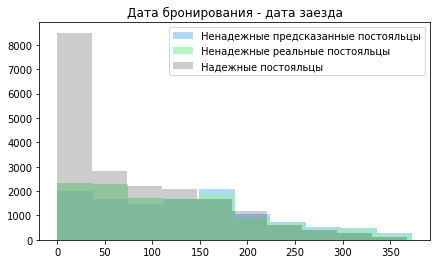

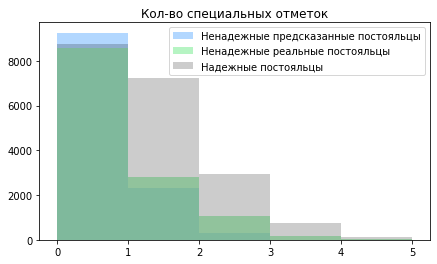

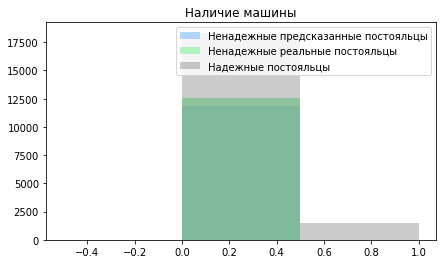

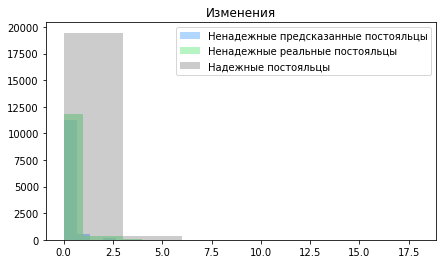

In [20]:
df_with_bad_boys = model.main.query('predict_logistic == 1')
df_with_bad_boys_real = model.main.query('is_canceled == 1')
df_with_good_boys_real = model.main.query('is_canceled == 0')
list_for_viz = [['lead_time', 'Дата бронирования - дата заезда', None],
                ['total_of_special_requests', 'Кол-во специальных отметок', 5],
                ['required_car_parking_spaces', 'Наличие машины',2],
                ['booking_changes', 'Изменения', 6]]
for col,titl,binans in list_for_viz:
    plt.figure(figsize=(7,4))
    plt.hist(df_with_bad_boys[col], alpha=0.7, label='Ненадежные предсказанные постояльцы', bins=binans)
    plt.hist(df_with_bad_boys_real[col], alpha=0.7, label='Ненадежные реальные постояльцы', bins=binans)
    plt.hist(df_with_good_boys_real[col], alpha=0.2, label='Надежные постояльцы', color='black', bins=binans)
    plt.title(titl)
    plt.legend()
    plt.show()

- Если человек бронирует за долго при этом очень длительное время не подтверждает бронь: зачастую клиент ненадежный
- Люди которые планируют приехать на машине, как правило не отменяют бронь
- Наличие специальных отметок, как правило говорит в пользу, того что человек приедет(скорее всего отметки связаны с тем что человек переживает, звонит и что то уточняет, соответственно такое поведение подтверждает серьезность намерений), а также такие люди вносят изменения в бронь
- Если человек уже приезжал, то это говорит в пользу его надежности  

### Шаг 6. Напишите общий вывод

- Введение депозита за спрогнозировано отмененную бронь потенциально увеличит прибыль компании, однако стоит отметить, что при таких условиях гораздо меньше будут бронировать номеров, а спрогнозировать на сколько меньше: на данный момент мы не можем, т.к. у нас нет статистики по такому роду информации.
- Также в тех.задание, не очень понятно какое кол-во убытков несет компания, в случае отмены бронирования

Рекомендации:
- Не смотря на то, что обученная модель прогнозирует довольно серьезное увеличение прибыли, я бы все таки рекомендовал отказаться от использования модели для прогнозирования: 
  - Если у одного снимут деньги за бронь, а другого нет, то такие действия несут в себе серьезные репутационные риски  
  - Модель не учитывает сколько людей просто напросто не будет бронировать.
- Ввести прозрачную политику бронирования, т.к. ненадежные клиенты имеют свойство бронировать за долгое время и после этого длительное время не подтверждать бронь, то в первую очередь стоит установить лимит на срок подтверждения брони, ввести депозит в случае отмены брони менее чем за 1-2недели до компании, тем самым защитив себя от незапланированных расходов.  
- Если клиент уже был, применять к нему более лояльные правила.